In [2]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold
import tqdm
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le



/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [48]:

# for pat in pat_list:
#     JJ.save_object(pat, '../patients/' + pat.id +'.p')

if_PSV = 0
if_sliding_window = 1
sw_size = 7
log = 0
p231_sw = modules.build_patients(231,90, if_PSV = if_PSV, if_sliding_window = if_sliding_window, sw_size = sw_size,log = log)
p231 = modules.build_patients(231,90, if_PSV = if_PSV, if_sliding_window = 0)
p241_sw = modules.build_patients(241,90, if_PSV = if_PSV, if_sliding_window = if_sliding_window, sw_size = sw_size,log = log)
p241 = modules.build_patients(241,90, if_PSV = if_PSV, if_sliding_window = 0)
p222_sw = modules.build_patients(2221,90, if_PSV = if_PSV, if_sliding_window = if_sliding_window, sw_size = sw_size,log = log)
p222 = modules.build_patients(2221,90, if_PSV = if_PSV, if_sliding_window = 0)
pat_list = [p231]

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


thres =  0.5714285714285714
label
False    192
True     188
Name: patient_id, dtype: int64
thres =  0.2857142857142857
label
False    177
True     148
Name: patient_id, dtype: int64
thres =  0.2857142857142857
label
False    133
True     123
Name: patient_id, dtype: int64


In [49]:
def plot_epoch_mean_both(pat_list, if_save = 0, label = '', if_title = 1, if_yrandom = 0):
    f, axarr = plt.subplots(2, sharex=True, figsize=(10,12))
    plot_epoch_mean_nsw(pat_list[0], label = label, if_yrandom = if_yrandom, ax = axarr[0])
    plot_epoch_mean_sw(pat_list[1], ax = axarr[0])
    
    axarr[1].plot(range(len(pat_list[0].daily.long_episodes)),list(pat_list[0].daily.long_episodes), color='black', marker='.',linewidth=1, markersize=5)
    axarr[1].set_xlabel('days', fontsize=hp.label_fontsize)
    axarr[1].set_ylabel('Long Episode Count', fontsize=hp.label_fontsize)
    plt.show()

In [50]:
def plot_epoch_mean_nsw(pat, ax, if_save = 0, label = '', if_title = 0, if_yrandom = 0):
    #first patient is the normal one, second one use sliding windows
    pat.print_features_property()
    ptid = pat.id
    dat = pat.daily
    dat_epi_agg, dat_le_agg, dat_epi_agg_ste, dat_le_agg_ste = prep.dat_agg(dat)

    xlabel = 'Epoch (month)'
    good_idx = []
    bad_idx = []

    epoch_label_dict = pat.epoch_label_dict
    for key, val in epoch_label_dict.items():
        if val:
            good_idx.append(key)
        else:
            bad_idx.append(key)

    good_r = []
    bad_r = []
    for key, val in pat.epoch_label_dict.items():
        if val:
            good_r.append(key)
        else:
            bad_r.append(key)   

    colors = [] #colors for plt.bar

    good_index = np.array(good_idx)*30 +15
    bad_index = np.array(bad_idx)*30 +15

    ax.errorbar(good_index, np.array(dat_le_agg.iloc[good_idx]),yerr=np.array(dat_le_agg_ste.iloc[good_idx]), fmt='o', mfc='green',ecolor='black', markersize='12',label = 'Good')
    ax.errorbar(bad_index, np.array(dat_le_agg.iloc[bad_idx]),yerr=np.array(dat_le_agg_ste.iloc[bad_idx]), fmt='o', mfc='pink',ecolor='black', markersize='12',label = 'Bad')
    ax.plot(np.arange(len(dat_le_agg)) * 30 + 15, dat_le_agg, label = 'Long Episode Mean', color = 'black')
    if if_title:
        plt.title('Epoch Label for Patient {0}'.format(ptid), fontsize=hp.label_fontsize)


    
    ax.set_xlabel(xlabel, fontsize=hp.label_fontsize)
    ax.set_ylabel('Mean Long Episode Count Per Day', fontsize=hp.label_fontsize)
    plt.tight_layout()
    ax.legend(fontsize=hp.label_fontsize-2)
    if if_save:
        directory = '../fig/mean_long_episode_count'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory + '/' + pat.id + label + 'mean_long_episode_count' + '.png')
        


In [51]:
def plot_epoch_mean_sw(pat, ax, if_save = 0, label = '', if_title = 0, if_yrandom = 0):
    #first patient is the normal one, second one use sliding windows
    pat.print_features_property()
    ptid = pat.id
    dat = pat.daily
    
    xlabel = 'days'
    good_idx = []
    good_val = []
    bad_idx = []
    bad_val = []
    n = dat.shape[0]
    
    idx = []
    vals = []
    for i in range(0,n):
        
        label = dat.label.iloc[i]
        val = dat.sw_val.iloc[i]
        idx.append(i)
        vals.append(val*2)
        if label:
            good_idx.append(i)
            good_val.append(val*2)
        else:
            bad_idx.append(i)
            bad_val.append(val*2)
    colors = [] #colors for plt.bar
    ax.plot(idx, vals, label = 'sliding window', color = 'green')
    ax.errorbar(np.array(good_idx), np.array(good_val),yerr=0, fmt='^', mfc='blue',ecolor='black', markersize='8',label = 'Good')
    ax.errorbar(np.array(bad_idx), np.array(bad_val),yerr=0, fmt='^', mfc='red',ecolor='black', markersize='8',label = 'Bad')
    
    if if_title:
        plt.title('Epoch Label for Patient {0}'.format(ptid), fontsize=hp.label_fontsize)


    ax.set_xlabel(xlabel, fontsize=hp.label_fontsize)
    plt.tight_layout()
    #ax.legend(fontsize=hp.label_fontsize-2)           


231
good:  537
bad:  356
total:  893
231
good:  481
bad:  421
total:  902


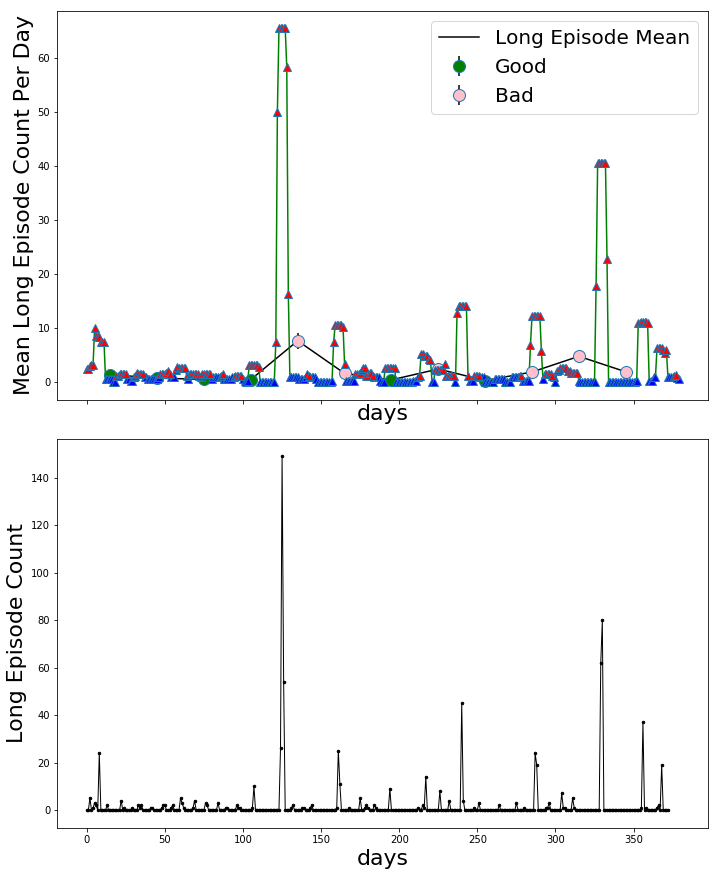

241
good:  281
bad:  288
total:  569
241
good:  273
bad:  306
total:  579


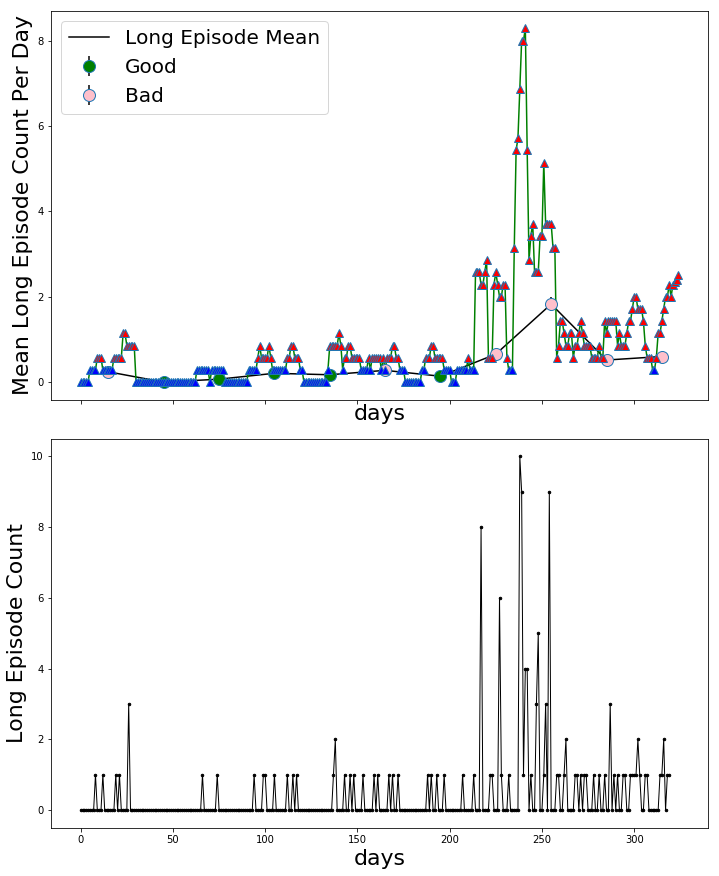

222_1
good:  276
bad:  452
total:  728
222_1
good:  362
bad:  387
total:  749


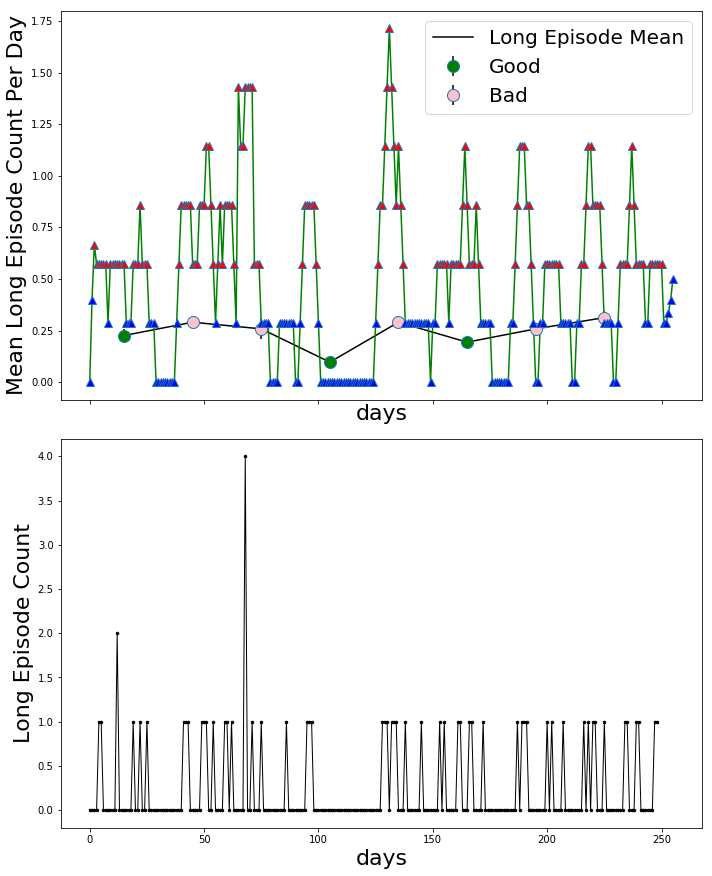

In [53]:
plot_epoch_mean_both([p231, p231_sw], if_save = 0, label = '', if_yrandom = 1)
plot_epoch_mean_both([p241, p241_sw], if_save = 0, label = '', if_yrandom = 1)
plot_epoch_mean_both([p222, p222_sw], if_save = 0, label = '', if_yrandom = 1)


In [25]:

# for pat in pat_list:
#     JJ.save_object(pat, '../patients/' + pat.id +'.p')

if_PSV = 0
if_sliding_window = 1
sw_size = 5
log = 1
p231_sw = modules.build_patients(231,90, if_PSV = if_PSV, if_sliding_window = if_sliding_window, sw_size = sw_size,log = log)
p231 = modules.build_patients(231,90, if_PSV = if_PSV, if_sliding_window = 0)
p241_sw = modules.build_patients(241,90, if_PSV = if_PSV, if_sliding_window = if_sliding_window, sw_size = sw_size,log = log)
p241 = modules.build_patients(241,90, if_PSV = if_PSV, if_sliding_window = 0)
p222_sw = modules.build_patients(2221,90, if_PSV = if_PSV, if_sliding_window = if_sliding_window, sw_size = sw_size,log = log)
p222 = modules.build_patients(2221,90, if_PSV = if_PSV, if_sliding_window = 0)
pat_list = [p231]

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


thres =  0.2772588722239781
label
False    195
True     185
Name: patient_id, dtype: int64
thres =  0.13862943611198905
label
False    225
True     100
Name: patient_id, dtype: int64
thres =  0.13862943611198905
label
False    169
True     87 
Name: patient_id, dtype: int64


231
good:  537
bad:  356
total:  893
231
good:  483
bad:  419
total:  902


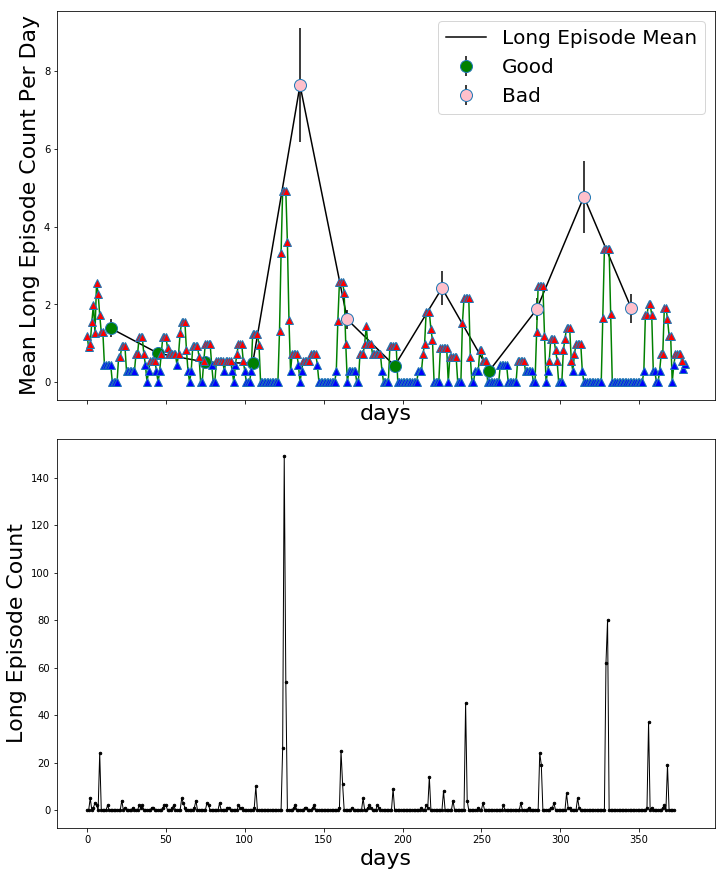

241
good:  281
bad:  288
total:  569
241
good:  189
bad:  390
total:  579


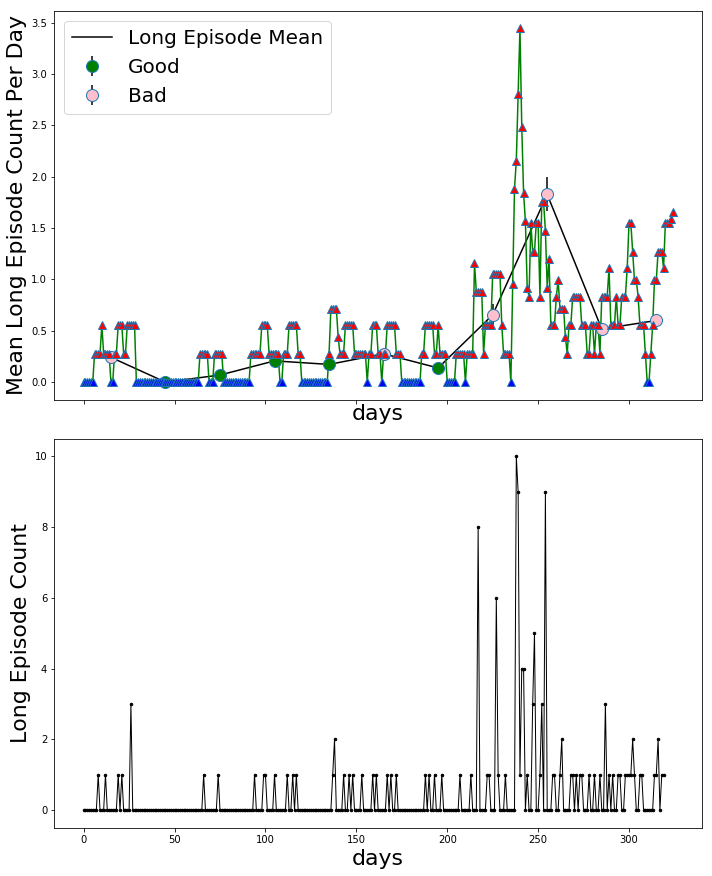

In [30]:
plot_epoch_mean_both([p231, p231_sw], if_save = 0, label = '', if_yrandom = 1)
plot_epoch_mean_both([p241, p241_sw], if_save = 0, label = '', if_yrandom = 1)
#plot_epoch_mean_both([p222, p222_sw], if_save = 0, label = '', if_yrandom = 1)


In [135]:
np.array([1,2,3] * 3)-5

array([-4, -3, -2, -4, -3, -2, -4, -3, -2])

In [124]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime 
import prep 
from hyperparams import Hyperparams as hp
prepath = '../data/'

epoch_info = {}
epoch_info['start'] =  datetime.strptime('Feb 7 2017', '%b %d %Y')
epoch_info['end'] = datetime.strptime('Feb 21 2018', '%b %d %Y')
num_per_epoch_231 = 31

col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le


pd.set_option('display.max_rows', 1000)

    
if_sliding_window = 1
k_ = 31



In [125]:
#self.if_sliding_window
if if_slideing_window:
    #self
    epoch_info['num_per_epoch'] = 1

NameError: name 'if_slideing_window' is not defined

In [82]:


dat= prep.prep_daily(pd.read_csv(prepath + 'NY231_2016-07-05_to_2018-06-12_daily_20180613153815.csv', skiprows=3))
# epoch_info = self.epoch_info

data0 = dat.loc[prep.filtertime(dat, hp.col_rs, epoch_info['start'], epoch_info['end']),:]

data_1 = prep.addepoch(dat, hp.col_rs, epoch_info['start'], epoch_info['end'], epoch_info['num_per_epoch'])
#self.if_sliding_window
if if_sliding_window:
#prep.
    data_2, epoch_label_dict, epoch_label_epi_dict = epoch_label_sw(data_1)
    print(data_2.groupby('label').agg('count').patient_id)
# self.epoch_label_dict = epoch_label_dict
# self.epoch_label_epi_dict = epoch_label_epi_dict
# self.daily = data_2

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


[2.3125     2.17647059 2.05555556 1.94736842 1.85       1.76190476
 1.68181818 1.7826087  1.70833333 1.68       1.61538462 1.55555556
 1.5        1.44827586 1.43333333 1.38709677 1.38709677 1.38709677
 1.29032258 1.32258065 1.35483871 1.25806452 1.19354839 1.19354839
 0.41935484 0.41935484 0.4516129  0.48387097 0.48387097 0.41935484
 0.41935484 0.41935484 0.41935484 0.4516129  0.51612903 0.58064516
 0.58064516 0.58064516 0.4516129  0.48387097 0.51612903 0.51612903
 0.51612903 0.51612903 0.51612903 0.64516129 0.74193548 0.77419355
 0.77419355 0.70967742 0.67741935 0.61290323 0.61290323 0.64516129
 0.77419355 0.77419355 0.77419355 0.74193548 0.70967742 0.70967742
 0.70967742 0.80645161 0.87096774 0.87096774 0.83870968 0.77419355
 0.70967742 0.70967742 0.70967742 0.80645161 0.77419355 0.70967742
 0.70967742 0.70967742 0.74193548 0.77419355 0.61290323 0.51612903
 0.48387097 0.48387097 0.48387097 0.5483871  0.58064516 0.61290323
 0.58064516 0.4516129  0.4516129  0.4516129  0.4516129  0.4516

In [25]:
def epoch_label_sw(dat):
    n = dat.shape[0]
    k = k_// 2
    epoch_label = {}
    sw_vals = np.zeros(n)
    for i in range(n):
        start = max(i-k,0)
        end = min(i+k,n)
        sw_vals[i] = np.mean(dat[col_le].iloc[start:end + 1])
        dat.loc[i, 'sw_val'] = val
    thres = np.median(sw_vals)
    keys = list(np.arange(n))
    vals = list(np.array(sw_vals < thres))
    epoch_label = dict(zip(keys, vals))
    for key in epoch_label:
        val = epoch_label[key]
        dat.loc[dat['epoch'] == key,'label'] = val
        
    return dat, epoch_label, None


label
False    194
True     186
Name: patient_id, dtype: int64

In [43]:
f = h5py.File('../data/features_90' + '231' + '.mat', 'r')
pat_id = 231
matlab_features_name = 'T_arr_scheduled'

col_names = hp.col_names
a = np.array(f[matlab_features_name]).T
features_0 = pd.DataFrame(np.array(f[matlab_features_name]).T, columns = col_names)
features_0

,filename,region_start_time,long_epi,sleep,Delta1,Delta2,Delta3,Delta4,Theta1,Theta2,...,HighGamma1,HighGamma2,HighGamma3,HighGamma4,Broadband1,Broadband2,Broadband3,Broadband4,i12,i34
0,1.311229e+17,6030.416875,0.0,0.0,166.695713,109.977805,379.143791,235.471506,271.221019,336.458920,...,23.704868,41.961200,9.194365,10.056550,1615.417356,1457.298660,1295.414860,837.738041,56.0,57.0
1,1.311229e+17,6030.667072,0.0,0.0,45.330649,25.745945,33.332776,25.287089,58.948647,40.290692,...,12.241259,14.571322,12.958672,12.118339,260.811449,296.069690,242.518597,157.842156,0.0,0.0
2,1.311229e+17,6030.917280,0.0,0.0,122.473730,120.454284,60.413538,35.564046,183.696672,165.570003,...,16.991401,20.910280,12.538677,11.714332,762.877934,642.858270,325.599995,194.300302,11.0,1.0
3,1.311229e+17,6031.167477,0.0,1.0,125.212355,68.151143,83.510747,30.763782,113.876178,174.092751,...,12.368370,14.982923,11.480795,10.097572,423.632146,597.174655,295.183099,163.599628,3.0,0.0
4,1.311238e+17,6031.416644,0.0,0.0,81.631204,36.404821,59.007060,32.875201,102.480948,53.468122,...,12.366594,14.875830,13.328144,11.390927,324.090829,301.602986,284.097780,150.137843,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,1.318093e+17,6825.656505,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2026,1.318102e+17,6826.156319,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2027,1.318102e+17,6826.406308,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2028,1.318102e+17,6826.656296,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
from datetime import date

d0 = date(2008, 8, 18)
d1 = date(2008, 9, 26)
delta = d1 - d0
print delta.days

In [ ]:
data0 = dat.loc[prep.filtertime(dat, hp.col_rs, self.epoch_info['start'], self.epoch_info['end']),:]
        epoch_info = self.epoch_info